In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import json
import glob, os, sys
%matplotlib inline


# Load data

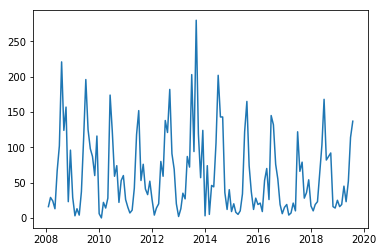

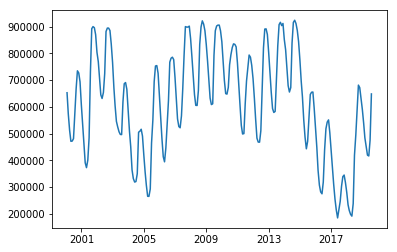

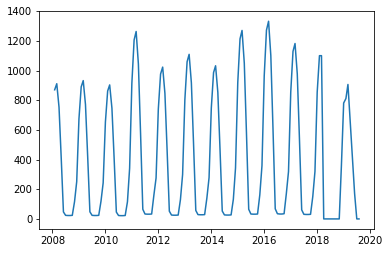

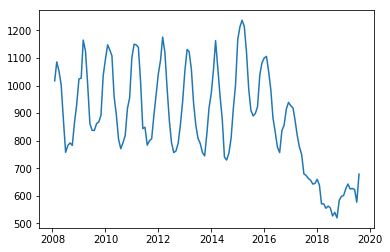

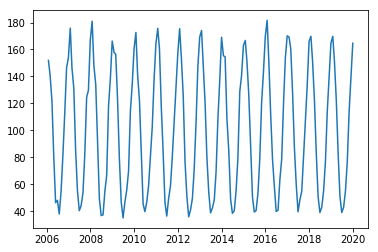

In [2]:
pr_mon=pd.read_json("./data/pr_mon_share.json") #in mm/month, from observations (mean of 5 stations located on dams)
plt.plot(pr_mon)
plt.show()

dam_mon=pd.read_json("./data/dam_mon_share.json") # in Ml, from CoCT data
plt.plot(dam_mon)
plt.show()

agric_mon=pd.read_json("./data/agric_mon_share.json") #in Ml/day, combination of sources - pre 2018 based on disaggregation of annual total, post-2018 - from CoCT water dashboard
plt.plot(agric_mon)
plt.show()

urban_mon=pd.read_json("./data/urban_mon_share.json") #in Ml/day, based on CoCT data
plt.plot(urban_mon)
plt.show()

pet_mon=pd.read_json("./data/pet_mon_share.json") #in mm/month, pre-2018 based on mean of P-M ET0 from ~35 met stations in the region, post-2018 - a repeat of 2018.
plt.plot(pet_mon)
plt.show()

# model

In [3]:
damnames=np.array(["BergRiver","SteenbrasLower","SteenbrasUpper","Theewaterskloof", "Volvlei","Vemmershoek"])
catchmentarea=np.array([172,36,36,176,539,121]) #area of quaternary catchments in which dams are located [km2]
print catchmentarea.sum()
damvolumes=np.array([130010, 33517, 31767, 480188, 164095, 58644]) #maximum volume of dams
damareas=np.array([4.88,3.8,np.nan,50.59,np.nan,2.96]) #area at maximum storage in km2. Not available for all dams
catchmentarea=np.array([172*0.76,36*.54,36*.54,176*1.00,539*0.75,121*0.90]) #this is a fraction of the quaternary catchment that drains to the dam, calculated in GIS from topography
print catchmentarea.sum()

1080
858.75
[ 0.00162523  0.00318129  0.0016      0.00692955  0.0016      0.00169395]


In [115]:
def bigsix_simple(_catchA, _Pthresh, _ow2pet, _prec, _use, _pet):
    #parameters that are not calibrated
    #volume-area relationship parameters
    damvolumes=np.array([130010., 33517., 31767., 480188., 164095., 58644.]) #max volume of dams, in Ml
    totstore=np.sum(damvolumes)
    print totstore
    damA=np.array([0.0016, 0.0031,  0.0016,0.0069,  0.0016,0.0016]) #characteristic of individual dams
    damB=0.68 #identical for all dams
    
    # getting time paramters
    allts=_prec.shape[0] #number of time steps
    print allts
    index=_prec.index #dates
    #preparing arrays to store state variables
    damevap=np.repeat(np.nan, allts).flatten()
    damarea=np.repeat(np.nan, allts).flatten()
    damvolume=np.repeat(np.nan, allts).flatten()
    catchrunoff=np.repeat(np.nan, _prec.shape[0]).flatten()
    
    #initial conditions    
    vol=totstore*0.7
    damvolume[0]=vol
    frac=vol/totstore
    A=np.sum(damA*((damvolumes*frac)**damB))
    damarea[0]=np.sum(damA*(vol**damB))

    nts=min(len(damvolume),_prec.shape[0], _use.shape[0]) #making sure that calculations are only for period for which all data are available
    for i in range(1,nts):
        #picking values from previous time step
        vol=damvolume[i-1]
        A=damarea[i-1]
        #pet
        pet=_pet.values[i] #in mm/month
        owevap=A*pet*ow2pet #km2*mm/month -result in Ml/month
        damevap[i]=owevap/30 #saving in Ml/day
        #effective precipitation
        Peff=_prec.values[i] #in mm/month
        Peff=Peff-_Pthresh
        #making sure that effective is not negative ;-)
        if Peff<0:
            Peff=0
        runoff=Peff*_catchA #roff in mm/month, catchA in km2 result in Ml/month
        use=_use.values[i] #reading water abstractions from dams
        #calculating new dam volume after inflow and outtakes and evaporation
        vol=vol-use-owevap+runoff
        #calculating overflow or spillover
        if vol>totstore:
            spill=vol-totstore
            vol=totstore
        else:
            spill=0
        #making sure dams don't dry below 0
        if vol<0:
            vol=0
        damvolume[i]=vol
        
        frac=vol/totstore
        A=np.sum(damA*((damvolumes*frac)**damB))  #this is distributed. assumed that dams are filled up uniformily. in km2
        damarea[i]=A

        catchrunoff[i]=runoff
    #preparing output dataframes
    damevap=pd.DataFrame(damevap, index=index)
    catchrunoff=pd.DataFrame(catchrunoff, index=index)
    damarea=pd.DataFrame(damarea, index=index)
    damvolume=pd.DataFrame(damvolume, index=index)
    
    return damvolume, damevap, damarea, catchrunoff

In [109]:
def bigsix(_catchA, _Pthresh, _beta, _maxsm, _alpha, _smevfac, _ow2pet, _prec, _use, _pet):
    #parameters that are not calibrated
    #volume-area relationship parameters
    damvolumes=np.array([130010., 33517., 31767., 480188., 164095., 58644.]) #max volume of dams, in Ml
    totstore=np.sum(damvolumes)
    print totstore
    damA=np.array([0.0016, 0.0031,  0.0016,0.0069,  0.0016,0.0016]) #characteristic of individual dams
    damB=0.68 #identical for all dams
    
    _maxsmevap=_smevfac*_maxsm # soil moisture at which there is maximum evaporation, in mm
    
    index=_prec.index #dates of the time series
    
    allts=_prec.shape[0] #number of time steps
    #preparing arrays to store state variables
    damevap=np.repeat(np.nan, allts).flatten()
    damarea=np.repeat(np.nan, allts).flatten()
    damvolume=np.repeat(np.nan, allts).flatten()
    soilm=np.repeat(np.nan, _prec.shape[0]).flatten()
    channel=np.repeat(np.nan, allts).flatten()
    catchrunoff=np.repeat(np.nan, _prec.shape[0]).flatten()    
    
    #initial conditions    
    vol=totstore*0.7
    damvolume[0]=vol
    frac=vol/totstore
    A=np.sum(damA*((damvolumes*frac)**damB))
    damarea[0]=np.sum(damA*(vol**damB))
    soilm[0]=_maxsm*0.2 
    channel[0]=10 

    nts=min(len(damvolume),_prec.shape[0], _use.shape[0]) #making sure that calculations are only for period for which all data are available
    for i in range(1,nts):
        #picking values from previous time step - thus initial conditions are needed
        vol=damvolume[i-1]
        sm=soilm[i-1]
        chan=channel[i-1]        
        A=damarea[i-1]
        
        #pet
        pet=_pet.values[i] #in mm/month
        owevap=A*pet*_ow2pet #km2*mm/month -result in Ml/month
        damevap[i]=owevap/30 #saving in Ml/day
        #effective precipitation
        Peff=_prec.values[i] #in mm/month
        Peff=Peff-_Pthresh
        #making sure that effective is not negative ;-)
        if Peff<0:
            Peff=0
        # runoff - fraction of Peff that is dependent on soil moisture
        roff=((sm/_maxsm)**_beta)*Peff #in mm/month
        infil=Peff-roff # mm/month - whatever is left after taking runoff off
        sm=sm+infil # mm - soil moisture increase from infiltration
        #evaporation from soil moisture
        if sm>_maxsmevap:
            smevapfrac=1
        else:
            smevapfrac=sm/_maxsmevap
        smevap=smevapfrac*pet # in mm/month
        sm=sm-smevap
        #making sure soil moisture is not negative
        if sm<0:
            sm=0
        #making sure soil moisture does not exceed maximum value
        if sm>_maxsm:
            roff=roff+(sm-_maxsm)
            sm=_maxsm
        #inflow to channel network
        inflow=roff*_catchA #roff in mm/month, catchA in km2 result in Ml/month
        #channel delay
        chan=chan+inflow
        strflow=chan*_alpha
        chan=chan-strflow
        channel[i]=chan
        use=_use.values[i] #reading water abstractions from dams
        #calculating new dam volume after inflow and outtakes and evaporation
        vol=vol-use-owevap+strflow
        #calculating overflow or spillover
        if vol>totstore:
            spill=vol-totstore
            vol=totstore
        else:
            spill=0
        #making sure dams don't dry below 0
        if vol<0:
            vol=0
        damvolume[i]=vol
        
        frac=vol/totstore
        A=np.sum(damA*((damvolumes*frac)**damB))  #this is distributed. assumed that dams are filled up uniformily. in km2
        damarea[i]=A
        
        soilm[i]=sm
        catchrunoff[i]=strflow
    #preparing dataframes
    damevap=pd.DataFrame(damevap, index=index)
    soilm=pd.DataFrame(soilm, index=index)
    catchrunoff=pd.DataFrame(catchrunoff, index=index)
    damarea=pd.DataFrame(damarea, index=index)
    damvolume=pd.DataFrame(damvolume, index=index)
    
    return damvolume, damevap, damarea, soilm, catchrunoff



In [110]:
ldate="2019 Jul"
prec_inp=pr_mon['2008':ldate]
pet_inp=pet_mon['2008':ldate]
dam_inp=dam_mon['2008':ldate]
use_inp=urban_mon['2008':ldate]*30+agric_mon['2008':ldate]*30 #in Ml/month

print prec_inp.shape, pet_inp.shape, dam_inp.shape, use_inp.shape

(139, 1) (139, 1) (139, 1) (139, 1)


898221.0


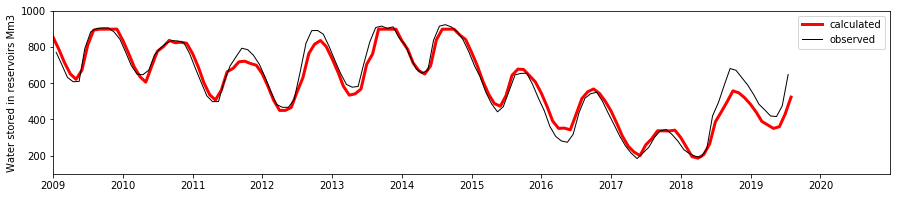

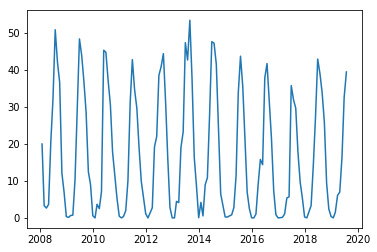

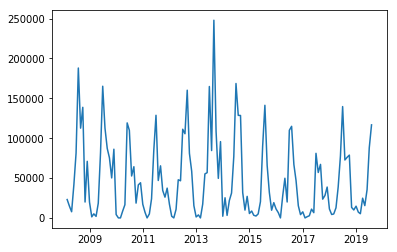

In [111]:
catchA=1000 #catchment area from data
#soil moisture-oriented paramterization
Pthresh=0 #rainfall threshold for calculating effective rainfall
beta=0.143 #infiltration-runoff partitioning
maxsm=100 #max soil moisture in partitioning function, but also in soil evaporation function
alpha=1 #channel network linear reservoir coefficient
smevfac=1.7 # soil moisture evaporation parameter
ow2pet=1.2 #ratio of open water to PET

damvolume, damevap, damarea, soilm, catchrunoff=bigsix(catchA, Pthresh, beta, maxsm, alpha, smevfac,ow2pet, prec_inp,use_inp,pet_inp)

fig=plt.figure(figsize=(15,3))
pl = fig.add_subplot(1, 1, 1)
pl.plot(damvolume/1000, color="red", label="calculated", linewidth=3)
pl.plot(dam_mon['2009':ldate].index-pd.Timedelta('15days'), dam_mon['2009':ldate].values/1000, color="black", label="observed", lw=1)
pl.set_ylabel("Water stored in reservoirs Mm3")
pl.legend()
pl.set_ylim(100,1000)
xticks=pd.date_range("2009-01-01", "2020-01-01", freq="AS")
pl.set_xlim("2009-01-01", "2021-01-01")
pl.set_xticks(xticks)
plt.show()

plt.plot(soilm)
plt.show()
plt.plot(catchrunoff)
plt.show()

898221.0
139


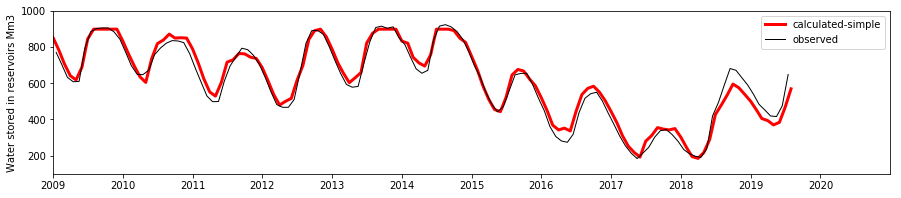

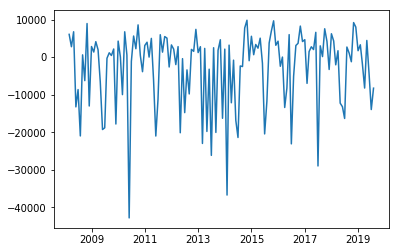

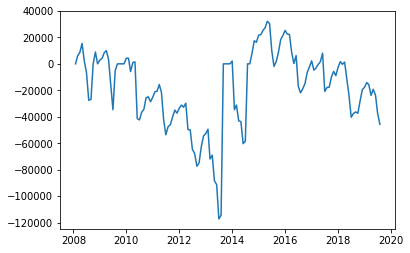

In [116]:
catchA=1000 #catchment area from data
Pthresh=12 #rainfall threshold for calculating effective rainfall
ow2pet=1.2

damvolume1, damevap1, damarea1,catchrunoff1=bigsix_simple(catchA, Pthresh, ow2pet, prec_inp,use_inp,pet_inp)


fig=plt.figure(figsize=(15,3))
pl = fig.add_subplot(1, 1, 1)
pl.plot(damvolume1/1000, color="red", label="calculated-simple", linewidth=3)
#pl.plot(damvolume/1000, color="blue", label="calculated", linewidth=3)
pl.plot(dam_mon['2009':ldate].index-pd.Timedelta('15days'), dam_mon['2009':ldate].values/1000, color="black", label="observed", lw=1)
pl.set_ylabel("Water stored in reservoirs Mm3")
pl.legend()
pl.set_ylim(100,1000)
xticks=pd.date_range("2009-01-01", "2020-01-01", freq="AS")
pl.set_xlim("2009-01-01", "2021-01-01")
pl.set_xticks(xticks)
plt.show()

plt.plot(catchrunoff-catchrunoff1)
plt.show()
plt.plot(damvolume-damvolume1)
plt.show()